In [2]:
import os
import nltk

import numpy as np
import pandas as pd
import sklearn

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from scipy.sparse.linalg import svds
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
NLTK_DATA_PATH = "./nltk_data"
nltk.download(['porter_test', 'rslp', 'wordnet'], download_dir=os.path.abspath(NLTK_DATA_PATH))
nltk.data.path.append(os.path.abspath(NLTK_DATA_PATH))

[nltk_data] Downloading package porter_test to /home/matej/dev/fit/bi-
[nltk_data]     vwm/lsi-vector-model/logic/nltk_data...
[nltk_data]   Package porter_test is already up-to-date!
[nltk_data] Downloading package rslp to /home/matej/dev/fit/bi-
[nltk_data]     vwm/lsi-vector-model/logic/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package wordnet to /home/matej/dev/fit/bi-
[nltk_data]     vwm/lsi-vector-model/logic/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Getting data

In [4]:
dataset = fetch_20newsgroups(
    subset='all', 
    data_home='./sklearn_data', 
    remove=('headers', 'footers', 'quotes')
)
documents = dataset.data

Example document before preprocessing

In [5]:
documents[0]

"\n\nI am sure some bashers of Pens fans are pretty confused about the lack\nof any kind of posts about the recent Pens massacre of the Devils. Actually,\nI am  bit puzzled too and a bit relieved. However, I am going to put an end\nto non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\nare killing those Devils worse than I thought. Jagr just showed you why\nhe is much better than his regular season stats. He is also a lot\nfo fun to watch in the playoffs. Bowman should let JAgr have a lot of\nfun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final\nregular season game.          PENS RULE!!!\n\n"

Pandas dataframe with documents

In [6]:
documents_df = pd.DataFrame({'document': documents})
documents_df

,document
0,\n\nI am sure some bashers of Pens fans are pr...
1,My brother is in the market for a high-perform...
2,\n\n\n\n\tFinally you said what you dream abou...
3,\nThink!\n\nIt's the SCSI card doing the DMA t...
4,1) I have an old Jasmine drive which I cann...
...,...
18841,DN> From: nyeda@cnsvax.uwec.edu (David Nye)\nD...
18842,\nNot in isolated ground recepticles (usually ...
18843,I just installed a DX2-66 CPU in a clone mothe...
18844,\nWouldn't this require a hyper-sphere. In 3-...


# Preprocessing documents

In [7]:
def clean_documents(df, min_word_length: int = 1):
    lemmatizer = WordNetLemmatizer()
    df['document_cleaned'] = pd.Series(df["document"])
    df['document_cleaned'] = (
        df['document_cleaned']
            .pipe(lambda x: x.str.lower())  # make all letters lowercase 
            .pipe(lambda x: x.str.replace("\S*@\S*\s?", "", regex=True)) # remove email addresses
            .pipe(lambda x: x.str.replace("[^a-zA-Z#]", " ", regex=True)) # remove non-alphabetical characters
            .pipe(lambda x: pd.Series([' '.join([lemmatizer.lemmatize(w) for w in line]) for line in x.str.split()])) # lemmatization
            .pipe(lambda x: pd.Series([' '.join([w for w in line if len(w) >= min_word_length]) for line in x.str.split()])) # get rid of short words
    )

In [8]:
clean_documents(documents_df, min_word_length=2)
documents_df

,document,document_cleaned
0,\n\nI am sure some bashers of Pens fans are pr...,am sure some bashers of pen fan are pretty con...
1,My brother is in the market for a high-perform...,my brother is in the market for high performan...
2,\n\n\n\n\tFinally you said what you dream abou...,finally you said what you dream about mediterr...
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,think it the scsi card doing the dma transfer ...
4,1) I have an old Jasmine drive which I cann...,have an old jasmine drive which cannot use wit...
...,...,...
18841,DN> From: nyeda@cnsvax.uwec.edu (David Nye)\nD...,dn from david nye dn neurology dn consultation...
18842,\nNot in isolated ground recepticles (usually ...,not in isolated ground recepticles usually an ...
18843,I just installed a DX2-66 CPU in a clone mothe...,just installed dx cpu in clone motherboard and...
18844,\nWouldn't this require a hyper-sphere. In 3-...,wouldn this require hyper sphere in space poin...


# Create term-by-document matrix

In [9]:
tfidf = TfidfVectorizer(stop_words='english')
tdm = tfidf.fit_transform(documents_df.document_cleaned)
terms = tfidf.get_feature_names()
print(f'Found {tdm.shape[1]} terms in {tdm.shape[0]} documents.')
print("Example terms:", terms[:20])

Found 77872 terms in 18846 documents.
Example terms: ['aa', 'aaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaauuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuugggggggggggggggg', 'aaaaarrrrgh', 'aaaall', 'aaack', 'aaaggghhh', 'aaah', 'aaahh', 'aaahhhh', 'aaai', 'aaaread', 'aab', 'aacc', 'aachen', 'aacs', 'aaef', 'aaf']


# SVD

## sklearn.decomposition.TruncatedSVD

In [10]:
tsvd = TruncatedSVD(n_components=15, random_state=42)
tdm_tsvd = tsvd.fit_transform(tdm)

In [11]:
for i, components in enumerate(tsvd.components_):
    terms_components = zip(terms, components)
    sorted_terms = sorted(terms_components, key=lambda x:x[1], reverse=True)[:10]
    print(f"Topic {str(i + 1).zfill(2)}: {[term[0] for term in sorted_terms]}")

Topic 01: ['wa', 'know', 'ha', 'don', 'like', 'just', 'people', 'think', 'time', 'doe']
Topic 02: ['window', 'drive', 'card', 'file', 'thanks', 'disk', 'driver', 'program', 'mb', 'scsi']
Topic 03: ['game', 'drive', 'wa', 'team', 'year', 'player', 'car', 'scsi', 'hockey', 'season']
Topic 04: ['drive', 'god', 'scsi', 'mb', 'ide', 'disk', 'controller', 'hard', 'card', 'floppy']
Topic 05: ['key', 'chip', 'government', 'encryption', 'clipper', 'phone', 'law', 'escrow', 'gun', 'algorithm']
Topic 06: ['wa', 'window', 'armenian', 'drive', 'file', 'problem', 'car', 'gun', 'did', 'israel']
Topic 07: ['thanks', 'car', 'mail', 'know', 'bike', 'looking', 'advance', 'list', 'email', 'doe']
Topic 08: ['card', 'wa', 'video', 'driver', 'monitor', 'chip', 'bit', 'bus', 'color', 'mode']
Topic 09: ['wa', 'thanks', 'key', 'mail', 'chip', 'god', 'file', 'information', 'address', 'armenian']
Topic 10: ['armenian', 'people', 'israel', 'card', 'game', 'arab', 'gun', 'government', 'jew', 'israeli']
Topic 11: ['

This is our **concept-by-term matrix**

In [12]:
tsvd.components_.shape

(15, 77872)

## scipy.sparse.linalg.svds

In [13]:
u, s, vt = svds(tdm, k=15)

In [14]:
display(tdm.shape)
display(u.shape)
display(s.shape)
display(vt.shape)

(18846, 77872)

(18846, 15)

(15,)

(15, 77872)

- **tdm matrix**: shape(number_of_documents, number_of_terms) $\Leftrightarrow$ term-by-document matrix
- **u matrix**: shape(number_of_documents, number_of_concepts) $\Leftrightarrow$ concept-by-document matrix
- **s vector**: shape(number_of_concepts,) $\Leftrightarrow$ concepts
- **vt matrix**: shape(number_of_concepts, number_of_terms) $\Leftrightarrow$ concept-by-term matrix

# Representing query

In [15]:
query = 'jagr'
query = query.split()

lemmatizer = WordNetLemmatizer()
for i, q in enumerate(query):
    query[i] = lemmatizer.lemmatize(q)
query_tdm = tfidf.transform(query)
query_tsvd = tsvd.transform(query_tdm) # probably not necessary
print(query_tdm.shape)
print(query_tsvd.shape)

(1, 77872)
(1, 15)


# Representing document

In [29]:
document_idx = 3
document_tdm = tdm[document_idx]
display(document_tdm)

<1x77872 sparse matrix of type '<class 'numpy.float64'>'
	with 39 stored elements in Compressed Sparse Row format>

# Cosine similarity

In [100]:
query_concepts = query_tdm @ np.transpose(vt) # query projection to the space of concepts --> concept-by-query
sim = cosine_similarity(u, query_concepts) # cosine similarity between concept-by-documents and concept-by-query
acos = np.arccos(sim)

## The best document for each word in query

In [101]:
best_documents = set()
for i in range(acos.shape[1]):
    print(query[i],end=" - ")
    print(np.argmin(acos[:, i]))
    best_documents.add(np.argmin(acos[:, i]))

Windows - 0


In [102]:
for document in best_documents:
    print(documents_df.iloc[document]["document"])
    print(100*"-")



I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killing those Devils worse than I thought. Jagr just showed you why
he is much better than his regular season stats. He is also a lot
fo fun to watch in the playoffs. Bowman should let JAgr have a lot of
fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final
regular season game.          PENS RULE!!!


----------------------------------------------------------------------------------------------------


## Results are merged, limit number of outputs

In [94]:
values_indexes = []
for i in range(acos.shape[1]):
    for j, val in enumerate(acos[:, i]):
        values_indexes.append({"query": query[i], "angle": val, "document_index": j})
values_indexes.sort(key=lambda x: x["angle"])

In [98]:
limit = 10

for x in values_indexes[:limit]:
    print(f"Query: {x['query']}, angle: {x['angle']}")
    print(documents_df.iloc[x["document_index"]]["document"])
    print(100*"-")

Query: Canada, angle: 0.4436661623229077

The probability is that the Oilers are not going anywhere.

Pocklington has chosen this moment to make his "last" stand is
because he is at the moment of maximum advantage...the provincial
government is months away from a provincial election...it is
the moment when he has maximum power to convince Northlands
to give him a better arena deal or a better purchase price...
and it is before the NHL's new collective agreement with
the players which might involve some enhanced revenue-sharing.

Pocklington is many things...stupid is not one of them.

He can dictate terms...because other cities will pay his
price if Edmonton doesn't.

Edmonton has already fucked up its international airport, and
surrendered supremacy to Calgary, and over the next few years
Edmonton is going to take a hard hit from government cutbacks.
It will screw itself beyond recogniton if it manages to find
a way to lose its hockey team too...because Northlands wants
to continue to

## Optimal number of components

The optimal number of components is 15


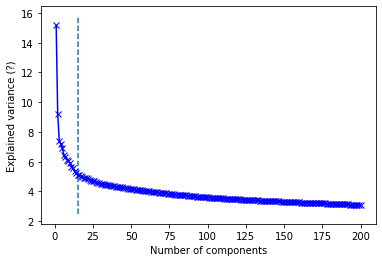

In [63]:
import matplotlib.pyplot as plt
from kneed import KneeLocator

_, s, _ = svds(tdm, k=200)

x = range(1, len(s)+1)
y = sorted(s, reverse=True)
kn = KneeLocator(x, y, curve='convex', direction='decreasing')
print(f"The optimal number of components is {kn.knee}")

plt.xlabel('Number of components')
plt.ylabel('Explained variance (?)')
plt.plot(x, y, 'bx-')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')


## Sequential search

In [ ]:
limit_sequential = 20

res = []
for term in query:
    indice = terms.index(term)
    col = tdm[:, indice]
    docs = [index for index, doc in enumerate(col) if doc > 0]
    res = [*res, *docs]
    
for i in res[:limit_sequential]:
    print(documents_df.loc[i, 'document'])
    print(100*'-')